In [1]:
!pip install treys
!pip install termcolor
!pip install pandas

In [2]:
import os
import time
import PIL.Image
import pandas as pd
import numpy as np
from typing import Union
from glob import glob
from treys import Card
from termcolor import colored

from collections import defaultdict

import sys
sys.path.insert(0, './src/')

from evaluation_utils import eval_listof_games , debug_listof_games, save_results , load_results, eval_listof_games_per_category

from table_extractor import TableExtractor
from card_extractor import CardExtractor
from card_classifier import CardClassifier
from chip_counter import ChipCounter

%load_ext autoreload
%autoreload 2

# [IAPR][iapr]: Project


**Group ID:** 11

**Author 1 (sciper):** Antoine Masanet (288366)  
**Author 2 (sciper):** Jonas Blanc (287508)   
**Author 3 (sciper):** Estée Granddier (343946) 

**Release date:** 29.04.2022


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous card player that we will name Bartick Pruel is willing to improve his poker skills. To do so, he asked our lab to design a tool that will automatically detect the hands of the players around the table. 

---

## 1. Data

To achieve your task, you will be given images that look like this (without the overlay)

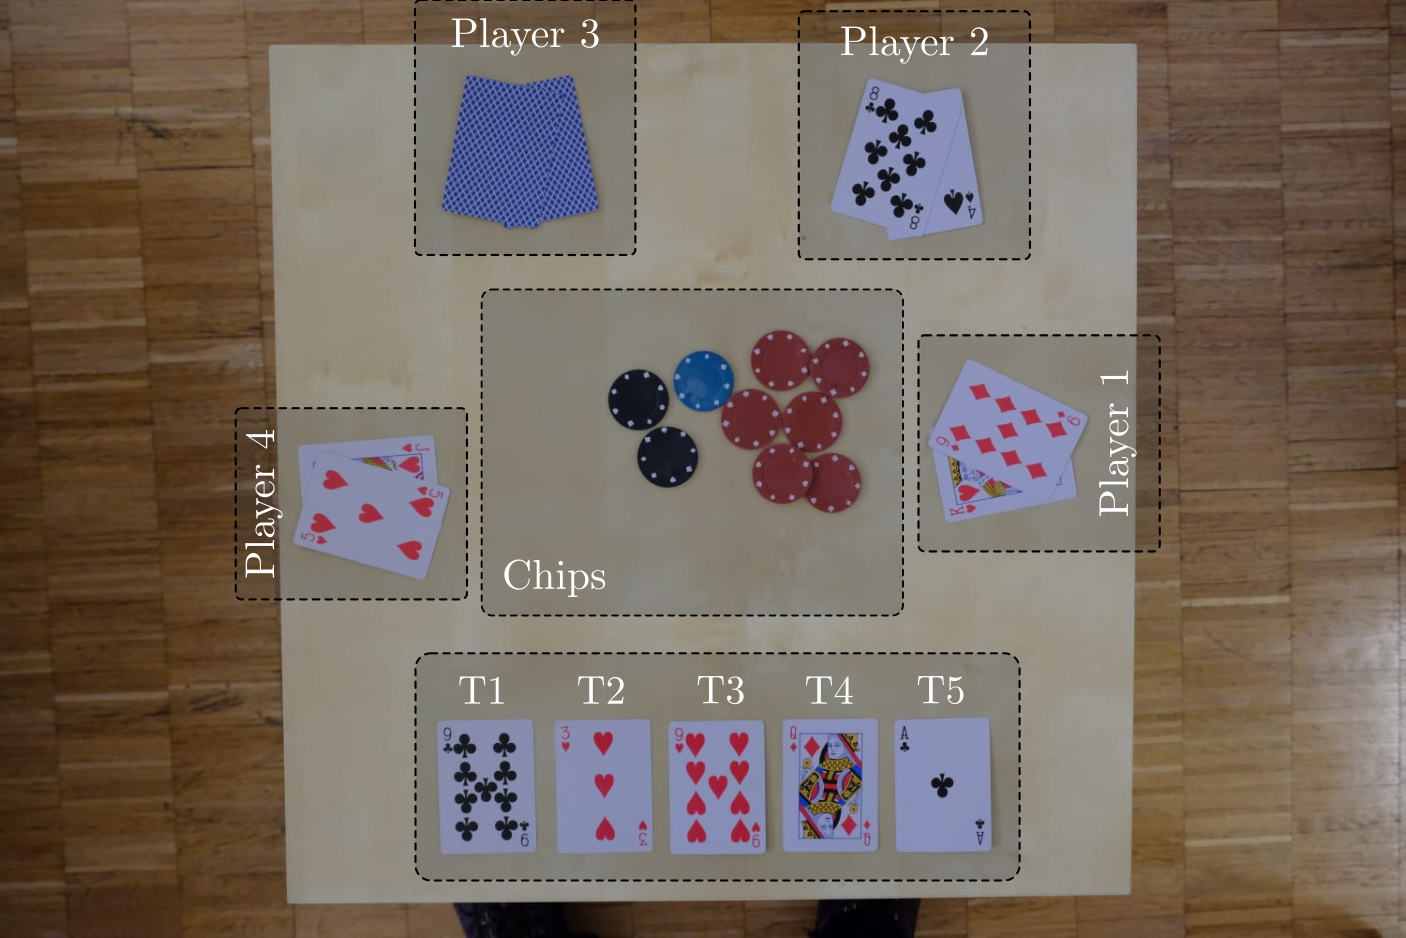


### 1.1. Table layout

The table is divided into 3 main parts:
* **Table cards (T1-T5)**: These cards are shared by every player. They are defined as the flop (T1-T3), the turn (T4) and the river (T5). The table cards are *always* visible.
* **Player cards (P11-P42)**: The cards played by each player (4 pairs). Each player *always* has 2 cards in hand. When a player is not playing, you can see the back of the cards (ex: player 3 here).
* **Chips**: The chips at the center of the table are named the pot.

### 1.2. Cards & Chips

The cards deck are composed of 52 cards split into 4 different colors: (D)imanond, (H)eart, (S)pade, (C)lub. Each color is composed of 13 different cards: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, (J)ack, (Q)ueen, (K)ing.

Th chips can be of 5 different colors: (r)ed, (g)reen, (b)lue, blac(k) or (w)hite.


### 1.3 Structure

You can download the data for the project here: [download data](https://drive.google.com/file/d/1d7rOe88kEK1CEaLvYgNZkxrtKImLVC9X/view)

```
data 
│
└─── image_setup
│    │    back_cards.jpg      # Back of the cards (either blue or red)
│    │    chips.jpg           # Set of chips used (red, green, blue, black, white)
│    │    kings.jpg           # Kings from the 4 colors (diamond, heart, spade, club)
│    │    spades_suits.jpg    # All cards of spades (1 - 10, Jack, Queen, King)
│    │    table.jpg           # Empty table
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.jpg        # Train image 00
│    │    ...
│    │    train_27.jpg        # Train image 27
│    └─── train_labels.csv    # Ground truth of the train set
│
└─── test
     │    test_00.jpg         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx             # Test image xx (day of the exam only)
```


---

## 2. Tasks


Your task is to predict the following parameters for a set of images.

* **T1** (str): String code of the first card of the flop (far left) 
* **T2** (str): String code of the second card of the flop
* **T3** (str): String code of the third card of the flop
* **T4** (str): String code of the turn
* **T5** (str): String code of the river


* **P11** (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
* **P12** (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
* **P21** (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
* **P22** (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
* **P31** (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
* **P32** (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
* **P41** (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
* **P42** (str or int): String code of player 4 card 2. Should be 0 if player 5 is not Playing.


* **CR** (int): Number of (r)ed chips in the pot
* **CG** (int): Number of (g)reen chips in the pot
* **CB** (int): Number of (b)lue chips in the pot
* **CK** (int): Number of blac(k) chips in the pot
* **CW** (int): Number of (w)hite chips in the pot


The output is saved using the function **save_results** as presented below.

---
## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** with few images, but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_game** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

In [3]:
def process_image(image, plot=False) -> dict:
    """
    Process image and return information. To return the value of the cards we use 
    the following format: {number}{color}. Where 
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(s).
            
    Parameters
    ----------
    image:
        Input image to process

    Returns
    -------
    results:
        - T1 (str): String code of the first card of the flop (far left) 
        - T2 (str): String code of the second card of the flop
        - T3 (str): String code of the third card of the flop
        - T4 (str): String code of the turn
        - T5 (str): String code of the river
        - P11 (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
        - P12 (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
        - P21 (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
        - P22 (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
        - P31 (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
        - P32 (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
        - P41 (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
        - P42 (str or int): String code of player 4 card 2. Should be 0 if player 4 is not Playing.
        - CR (int): Number of (r)ed chips in the pot
        - CG (int): Number of (g)reen chips in the pot
        - CB (int): Number of (b)lue chips in the pot
        - CK (int): Number of blac(k) chips in the pot
        - CW (int): Number of (w)hite chips in the pot
        
    Examples
    --------
    - QH: Queen of hearths
    - 10S: 10 of spades
    - AC: Ace f clubs

    """
    def def_value():
        return "0"
      
    results = defaultdict(def_value)
    
    image = np.array(image)
    
    # Extract table
    table_img = TableExtractor.extract_table(image, plot=plot)
    
    # Extract cards
    card_extractor = CardExtractor(table_img)
    
    
    # Classify bottom cards
    table_card_keys = ["T1", "T2", "T3", "T4", "T5"]
    table_cards = card_extractor.extract_table_cards(plot=plot)
    CardClassifier.classify_cards(table_cards, table_card_keys, results, can_use_both_corners=True, plot=plot)
    
    players = ["P1", "P2", "P3", "P4"]
    for player in players:
        if (plot):
            print(player)
        c1, c2 = card_extractor.extract_player_cards(player, plot=plot)
        
        first_card_name = player + "1"
        second_card_name = player + "2"

        is_face_down = False
        if (type(c1) != type(None)):
            is_face_down |= CardClassifier.is_card_face_down(c1, plot=plot)
            if(not is_face_down):
                results[first_card_name], _ = CardClassifier.classify_card(c1, can_use_both_corners=False, plot =plot)
                
        if (type(c2) != type(None)):
            is_face_down |= CardClassifier.is_card_face_down(c2, plot=plot)
            if(not is_face_down):
                results[second_card_name], _ = CardClassifier.classify_card(c2, can_use_both_corners=False, plot=plot)
        if(is_face_down):
            results[first_card_name] = "0"
            results[second_card_name] = "0"
            
    # Chips
    ChipCounter.count_chips(table_img, results, plot=plot)
    
    return results

In [4]:
## load train size dataset
path_data = "data/train"
group_id = 11

In [5]:
## load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate three images
games_id = range(28)

for i in games_id :
    
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    start_time = time.time()
    results = process_image(image=im, plot=False)
    # Append result to array
    game_results[i] = results
    
    print(f"Predicted game {i} in {time.time() - start_time}s")



# Outputs prediction of game 0
#print("Prediciton game:\n\t{}: {}".format(0, game_results[0])) #overlay

Size of trainset:
	28
Predicted game 0 in 3.7135848999023438s
Predicted game 1 in 3.599686861038208s
Predicted game 2 in 3.728595018386841s
Predicted game 3 in 3.456023931503296s
Predicted game 4 in 4.210814952850342s
Predicted game 5 in 4.824161052703857s
Predicted game 6 in 3.6731441020965576s
Predicted game 7 in 4.558768272399902s
Predicted game 8 in 4.070819854736328s
Predicted game 9 in 3.8265421390533447s
Predicted game 10 in 4.043745040893555s
Predicted game 11 in 5.971634864807129s
Warning circle with no thresholded color: set to label of closest color mean
Warning circle with no thresholded color: set to label of closest color mean
Predicted game 12 in 4.002073764801025s
Predicted game 13 in 5.198171854019165s
Predicted game 14 in 3.584688901901245s
Predicted game 15 in 4.5925188064575195s
Predicted game 16 in 4.1251819133758545s
Predicted game 17 in 3.479093074798584s
Predicted game 18 in 3.972456932067871s
Predicted game 19 in 4.554895877838135s
Predicted game 20 in 4.634046

In [6]:
# Saving results
file_results = save_results(results=game_results, groupid=group_id)

In [7]:
# Checking the results were loaded correctly
loaded_results = load_results(file_results)
print(loaded_results.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27'])


# Evaluation and Debugging

In [8]:
# Read training data
game_labels = pd.read_csv('data/train/train_labels.csv')
game_labels = game_labels.fillna('0')
# game_labels

In [9]:
eval_listof_games_per_category(game_results , game_labels , game_id = games_id)

Game 0 results
Num: 1.0
Suits: 1.0
Chips:1.0
________________________________________
Game 1 results
Num: 1.0
Suits: 1.0
Chips:1.0
________________________________________
Game 2 results
Num: 1.0
Suits: 0.9230769230769231
Chips:1.0
________________________________________
Game 3 results
Num: 0.9230769230769231
Suits: 1.0
Chips:1.0
________________________________________
Game 4 results
Num: 0.6923076923076923
Suits: 0.46153846153846156
Chips:0.875
________________________________________
Game 5 results
Num: 0.9230769230769231
Suits: 0.8461538461538461
Chips:1.0
________________________________________
Game 6 results
Num: 0.9230769230769231
Suits: 0.6153846153846154
Chips:1.0
________________________________________
Game 7 results
Num: 1.0
Suits: 1.0
Chips:1.0
________________________________________
Game 8 results
Num: 1.0
Suits: 0.9230769230769231
Chips:1.0
________________________________________
Game 9 results
Num: 0.8461538461538461
Suits: 0.8461538461538461
Chips:1.0
_____________

Current best on training set
- Average SCORE num =  0.9478021978021979
- Average SCORE suits =  0.925824175824176
- Average SCORE chips =  0.9900412087912088

In [10]:
# Evaluate
eval_listof_games( game_results , game_labels , game_id = games_id)

Game 0 results
Estimated game
['2C', '6H', '8D', 'JC', 'JS', '2H', '4S', 'KS', 'QS', 'KD', '5S', '7H', '8C', 1, 1, 1, 1, 1]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8C' 1 1 1 1
 1]


             	scores
Card number 	1.0 %
Card suit   	1.0 %
Chips       	1.0 %


FINAL score 	1.0 %
________________________________________
Game 1 results
Estimated game
['9H', '8C', '2H', '4C', 'JS', '0', '0', '3C', 'KH', 'KD', '2D', 'QS', '3S', 2, 0, 1, 0, 1]
True game
['9H' '8C' '2H' '4C' 'JS' '0' '0' '3C' 'KH' 'KD' '2D' 'QS' '3S' 2 0 1 0 1]


             	scores
Card number 	1.0 %
Card suit   	1.0 %
Chips       	1.0 %


FINAL score 	1.0 %
________________________________________
Game 2 results
Estimated game
['9D', '3D', '4C', '6D', '2H', '7H', 'QD', '10S', '10S', '5C', '4S', '2S', '4H', 0, 0, 8, 1, 0]
True game
['9D' '3D' '4C' '6D' '2H' '7H' 'QD' '10S' '10C' '5C' '4S' '2S' '4H' 0 0 8
 1 0]


             	scores
Card number 	1.0 %
Card suit   	0.92 %
Chips       	1.0 %


0.9545558608058607

Best training set score: 0.9545558608058607  
- Solved: 0, 1, 7, 10, 15, 17, 20, 21, 24, 25, 26, 27
- Difficult: 4, 6, 12, 23

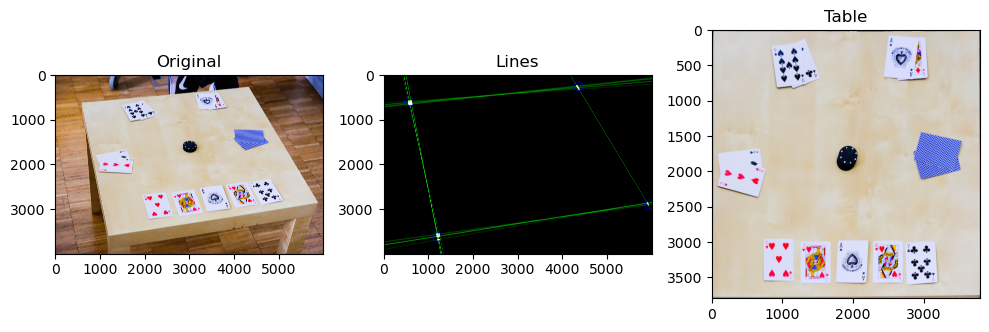

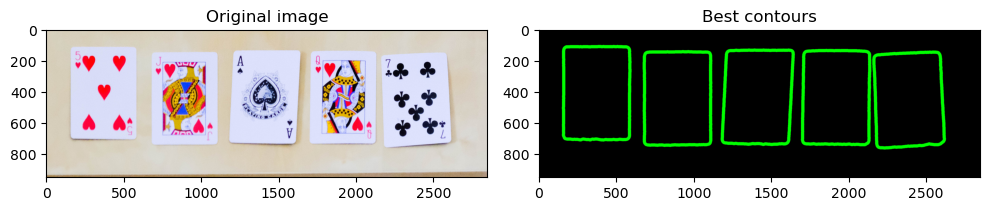

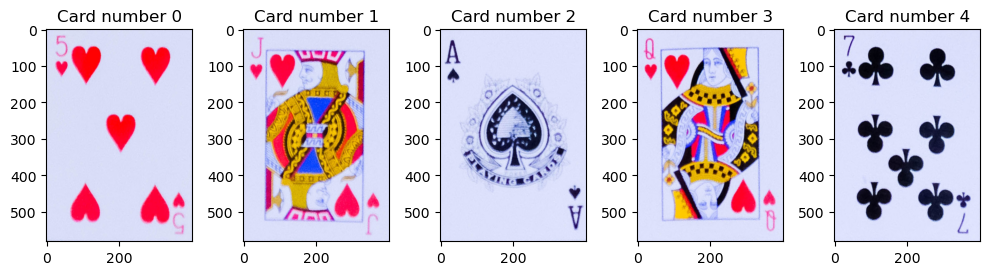

Predicted: 5H with score char:0.6763888888888889, symbol:0.8216106014271152
Predicted: JH with score char:0.8046875, symbol:0.8267074413863404
Predicted: AS with score char:0.7555350553505535, symbol:0.659016393442623
Predicted: QH with score char:0.8297619047619048, symbol:0.8757637474541752
Predicted: 7C with score char:0.7633928571428571, symbol:0.8646616541353384
P1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracted player card with height pipeline: is top card:True
Extracted player card with height pipeline: is top card:False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


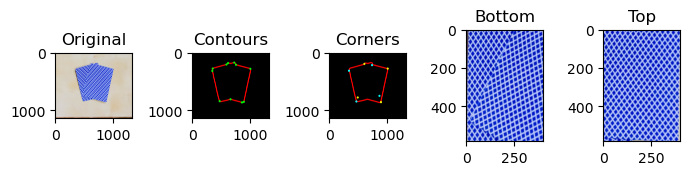

FACE DOWN
FACE DOWN
P2
Extracted player card with width pipeline: is top card:False
Extracted player card with height pipeline: is top card:True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


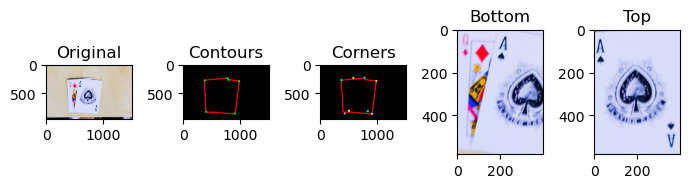

Predicted: QD with score char:0.5543933054393305, symbol:0.62248322147651
Predicted: AS with score char:0.6535008976660682, symbol:0.4988962472406181
P3
Extracted player card with height pipeline: is top card:False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracted player card with height pipeline: is top card:True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


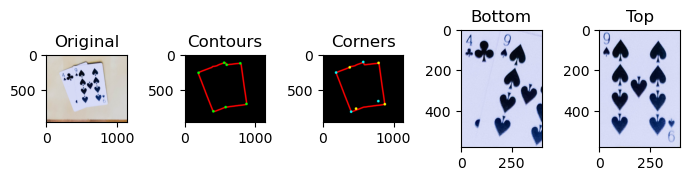

Predicted: 4S with score char:0.5555555555555556, symbol:0.7247899159663865
Predicted: 9S with score char:0.32774869109947646, symbol:0.7752442996742671
P4
Extracted player card with height pipeline: is top card:True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracted player card with height pipeline: is top card:False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


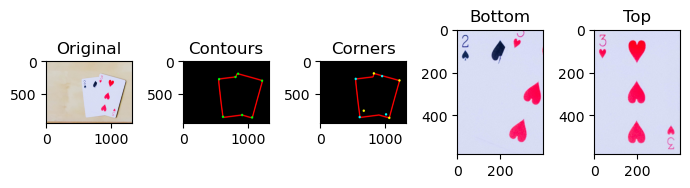

Predicted: 2S with score char:0.7720125786163522, symbol:0.8170865279299014
Predicted: 3H with score char:0.7293447293447294, symbol:0.883130081300813


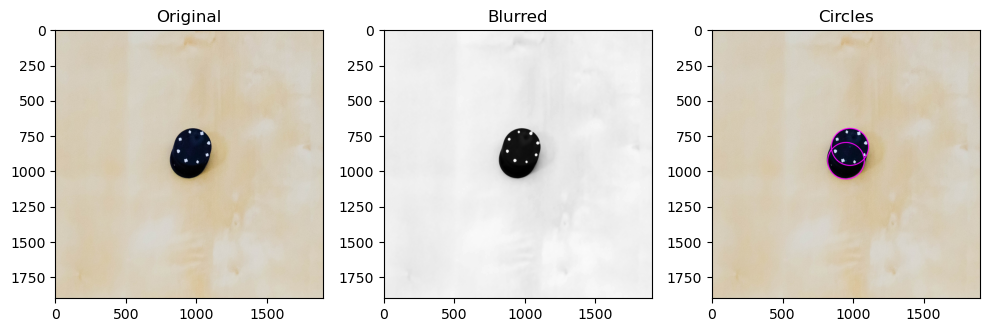

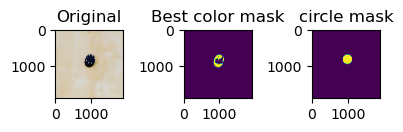

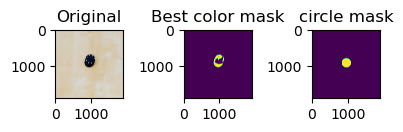

In [11]:
# open the image
im = PIL.Image.open("./data/image_setup/ultimate_test.jpg")
# Process the image
results = process_image(image=im, plot= True)